In [1]:
import pandas as pd
import utils
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import datetime as dt

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

# Introduction

In this notebook we will explore a data set of my personal listening history, along with features and statistics on each song (some already computed and extracted from the Spotify API, others computed from 30 seconds samples of the song and Librosa) to deduce if we can derive a relationship between each song's features and the extent to which the song personally captivated me. 

Additionally, we will identify my most listened to tracks, binge worthy tracks, and dependable tracks (to be defined later). Lastly, we will perform arithmetic operations on vector representations of songs to arrive at songs that represent the "average" of two songs or the "difference" of two songs. 

First, we must compile and update my listening history into a format that will be easy to work with.

In [2]:
streams = pd.read_csv('output/processed_streams.csv')
# As a result of storing as a .csv file, lists are stored as strings, so we must convert back
streams['artist_genres'] = streams['artist_genres'].apply(lambda x: literal_eval(x))

saved_tracks = pd.read_csv('output/saved_tracks.csv', index_col = 'track_key')
# As a result of storing as a .csv file, lists are stored as strings, so we must convert back
saved_tracks['artist_genres'] = saved_tracks['artist_genres'].apply(lambda x: literal_eval(x))

## The Data
The `saved_tracks` table includes the entirety of my saved tracks library since my account's conception in 2014 to today's date: September 13th, 2021. The `streams` table includes the entirety of my Spotify listening history from March 13th, 2020 to March 13th, 2021. Additional features have been pulled using the [Spotify Web API](https://developer.spotify.com/documentation/web-api/reference/) and by processing 30 second samples of each song using the [Librosa](https://librosa.org) library. The process of collecting features can be viewed in `extrasct_saved_tracks_data.ipynb`

Columns of the `saved_tracks` and `streams` table include:

Identification metrics: 
- `track_key`: Unique key generated from a combination of track name and artist name 
- `track_name`: Name of the track
- `artist_name`: Name of the track's primary artist
- `album_name`: Name of the album that the track is from
- `track_id`: Spotify ID of the track
- `artist_id`: Spotify ID of the track's artist
- `album_id`: Spotify ID of the album from which the track is from
- `added_at`: The time at which the track was added to my saved songs

Spotify API Track Audio Features:
- `danceability`: How suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity (a value of 0.0 is least danceable and 1.0 is most danceable)
- `energy`: A measure from 0.0 to 1.0 that represents a perceptual measure of intensity and activity (a value of 1.0 represents high energy)
- `key`: The key the track is in (integers map to pitches using standard Pitch Class notation)
- `loudness`: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.
- `mode`: The modality (major or minor) of a track, the type of scale from which its melodic content is derived (Major is represented by 1 and minor is 0)
- `speechiness`: Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.
- `acousticness`: A confidence measure from 0.0 to 1.0 of whether the track is acoustic (1.0 represents high confidence the track is acoustic)
- `instrumentalness`: Predicts whether a track contains no vocals.“Ooh” and “aah” sounds are treated as instrumental in this context (a score of 1.0 represents a greater likelihood that the track contains no vocals)
- `liveness`: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
- `valence`: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- `tempo`: The overall estimated tempo of a track in beats per minute (BPM) (tempo is the speed or pace of a given piece)
- `duration_ms`: The duration of the track in milliseconds
- `time_signature`: Estimated overall time signature, or notational convention to specify how many beats are in each bar (or measure)of a track

30 Second Sample Calculated Audio Features:
- `tempo_calc`: The calculated tempo of the track's sample
- `zcr`*: The zero crossing rate (rate at which a signal changes its sign from positive to negative or vice versa; good at extracting information about percussive sounds)
- `mfccs`*: The first 13 Mel Frequency Cepstral Coefficients (a cepstral representation of the short-term power spectrum of the track's sample)
- `spectral_contrast`*: the decibel difference between peaks and valleys in the spectrum (captures the time-varying behavior of the track's sample)
- `chroma`*: a condensed representation of sound in which the entire spectrum is projected onto the 12 distinct semitones / chroma of the musical octave (captures harmonic and melodic elements of music)
- `tonnetz`*: maps an audio clip to a standard representation of the tonal landscape (used to capture harmonic motion between chords and modulation between keys)
- `spectral_flatness`*: a measure to quantify how close an audio clip is to being pure noise (captures how tonal vs. noisy the audio clip is)
- `rms`*: The root mean square of the audio signal representing its "average" (captures the loudness and strength of the signal)
- `spectral_centroid`*: Characterizes where the center of mass of the audio clips spectrum is (has been shown to have a robust connection with the impression of brightness of a sound)
- `spectral_bandwidth`*: The variance from the spectral centroid of an audio signal
- `energy`*: similar to the Spotify API's `energy` feature in that it attempts to capture the intensity and activity of the audio clip


\* indicates that the first 5 moments of the features distribution were stored to maintain optimal space efficiency, along with the standard deviation, minimum, maximum, median

Other:
- `artist_genres`: A list of the genres the artist is associated with

Popularity Metrics: 
- `track_popularity`: Spotify's representation of the popularity of the track between 0 and 100, with 100 being the most popular
- `album_popularity`: Spotify's representation of the popularity of the album from which the track comes from between 0 and 100, with 100 being the most popular
- `artist_popularity`: Spotify's representation of the popularity of the artist the track is by between 0 and 100, with 100 being the most popular
- `artist_followers`: The number of followers that the artist has on Spotify

In [3]:
saved_tracks = saved_tracks.sort_values('added_at', ascending = False)
saved_tracks.head()

,track_name,artist_name,album_name,track_id,artist_id,album_id,artist_genres,artist_followers,artist_popularity,album_popularity,preview_url,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity,added_at,tempo_calc,energy_mean,energy_var,energy_std,energy_min,energy_max,energy_median,energy_kurt,energy_skew,rms_mean,rms_var,rms_std,rms_min,rms_max,rms_median,rms_kurt,rms_skew,zcr_mean,zcr_var,zcr_std,zcr_min,zcr_max,zcr_median,zcr_kurt,zcr_skew,spec_flat_mean,spec_flat_var,spec_flat_std,spec_flat_min,spec_flat_max,spec_flat_median,spec_flat_kurt,spec_flat_skew,spec_cent_mean,spec_cent_var,spec_cent_std,spec_cent_min,spec_cent_max,spec_cent_median,spec_cent_kurt,spec_cent_skew,spec_band_mean,spec_band_var,spec_band_std,spec_band_min,spec_band_max,spec_band_median,spec_band_kurt,spec_band_skew,mfcc1_mean,mfcc1_var,mfcc1_std,mfcc1_med,mfcc1_min,mfcc1_max,mfcc1_kurt,mfcc1_skew,mfcc2_mean,mfcc2_var,mfcc2_std,mfcc2_med,mfcc2_min,mfcc2_max,mfcc2_kurt,mfcc2_skew,mfcc3_mean,mfcc3_var,mfcc3_std,mfcc3_med,mfcc3_min,mfcc3_max,mfcc3_kurt,mfcc3_skew,mfcc4_mean,mfcc4_var,mfcc4_std,mfcc4_med,mfcc4_min,mfcc4_max,mfcc4_kurt,mfcc4_skew,mfcc5_mean,mfcc5_var,mfcc5_std,mfcc5_med,mfcc5_min,mfcc5_max,mfcc5_kurt,mfcc5_skew,mfcc6_mean,mfcc6_var,mfcc6_std,mfcc6_med,mfcc6_min,mfcc6_max,mfcc6_kurt,mfcc6_skew,mfcc7_mean,mfcc7_var,mfcc7_std,mfcc7_med,mfcc7_min,mfcc7_max,mfcc7_kurt,mfcc7_skew,mfcc8_mean,mfcc8_var,mfcc8_std,mfcc8_med,mfcc8_min,mfcc8_max,mfcc8_kurt,mfcc8_skew,mfcc9_mean,mfcc9_var,mfcc9_std,mfcc9_med,mfcc9_min,mfcc9_max,mfcc9_kurt,mfcc9_skew,mfcc10_mean,mfcc10_var,mfcc10_std,mfcc10_med,mfcc10_min,mfcc10_max,mfcc10_kurt,mfcc10_skew,mfcc11_mean,mfcc11_var,mfcc11_std,mfcc11_med,mfcc11_min,mfcc11_max,mfcc11_kurt,mfcc11_skew,mfcc12_mean,mfcc12_var,mfcc12_std,mfcc12_med,mfcc12_min,mfcc12_max,mfcc12_kurt,mfcc12_skew,mfcc13_mean,mfcc13_var,mfcc13_std,mfcc13_med,mfcc13_min,mfcc13_max,mfcc13_kurt,mfcc13_skew,mfcc14_mean,mfcc14_var,mfcc14_std,mfcc14_med,mfcc14_min,mfcc14_max,mfcc14_kurt,mfcc14_skew,mfcc15_mean,mfcc15_var,mfcc15_std,mfcc15_med,mfcc15_min,mfcc15_max,mfcc15_kurt,mfcc15_skew,mfcc16_mean,mfcc16_var,mfcc16_std,mfcc16_med,mfcc16_min,mfcc16_max,mfcc16_kurt,mfcc16_skew,mfcc17_mean,mfcc17_var,mfcc17_std,mfcc17_med,mfcc17_min,mfcc17_max,mfcc17_kurt,mfcc17_skew,mfcc18_mean,mfcc18_var,mfcc18_std,mfcc18_med,mfcc18_min,mfcc18_max,mfcc18_kurt,mfcc18_skew,mfcc19_mean,mfcc19_var,mfcc19_std,mfcc19_med,mfcc19_min,mfcc19_max,mfcc19_kurt,mfcc19_skew,mfcc20_mean,mfcc20_var,mfcc20_std,mfcc20_med,mfcc20_min,mfcc20_max,mfcc20_kurt,mfcc20_skew,spec_cont1_mean,spec_cont1_var,spec_cont1_std,spec_cont1_med,spec_cont1_min,spec_cont1_max,spec_cont1_kurt,spec_cont1_skew,spec_cont2_mean,spec_cont2_var,spec_cont2_std,spec_cont2_med,spec_cont2_min,spec_cont2_max,spec_cont2_kurt,spec_cont2_skew,spec_cont3_mean,spec_cont3_var,spec_cont3_std,spec_cont3_med,spec_cont3_min,spec_cont3_max,spec_cont3_kurt,spec_cont3_skew,spec_cont4_mean,spec_cont4_var,spec_cont4_std,spec_cont4_med,spec_cont4_min,spec_cont4_max,spec_cont4_kurt,spec_cont4_skew,spec_cont5_mean,spec_cont5_var,spec_cont5_std,spec_cont5_med,spec_cont5_min,spec_cont5_max,spec_cont5_kurt,spec_cont5_skew,spec_cont6_mean,spec_cont6_var,spec_cont6_std,spec_cont6_med,spec_cont6_min,spec_cont6_max,spec_cont6_kurt,spec_cont6_skew,spec_cont7_mean,spec_cont7_var,spec_cont7_std,spec_cont7_med,spec_cont7_min,spec_cont7_max,spec_cont7_kurt,spec_cont7_skew,chroma1_mean,chroma1_var,chroma1_std,chroma1_med,chroma1_min,chroma1_max,chroma1_kurt,chroma1_skew,chroma2_mean,chroma2_var,chroma2_std,chroma2_med,chroma2_min,chroma2_max,chroma2_kurt,chroma2_skew,chroma3_mean,chroma3_var,chroma3_std,chroma3_med,chroma3_min,chroma3_max,chroma3_kurt,chroma3_skew,chroma4_mean,chroma4_var,chroma4_std,chroma4_med,chroma4_min,chroma4_max,chroma4_kurt,chroma4_skew,chroma5_mean,chroma5_var,chroma5_std,chroma5_med,chroma5_min,chroma5_max,chroma5_kurt,chroma5_skew,

In [4]:
streams = streams.sort_values('end_time', ascending = False)
streams.head()

,track_key,track_name,artist_name,album_name,track_id,artist_id,album_id,artist_genres,artist_followers,artist_popularity,album_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity,preview_url,tempo_calc,energy_mean,energy_var,energy_std,energy_min,energy_max,energy_median,energy_kurt,energy_skew,rms_mean,rms_var,rms_std,rms_min,rms_max,rms_median,rms_kurt,rms_skew,zcr_mean,zcr_var,zcr_std,zcr_min,zcr_max,zcr_median,zcr_kurt,zcr_skew,spec_flat_mean,spec_flat_var,spec_flat_std,spec_flat_min,spec_flat_max,spec_flat_median,spec_flat_kurt,spec_flat_skew,spec_cent_mean,spec_cent_var,spec_cent_std,spec_cent_min,spec_cent_max,spec_cent_median,spec_cent_kurt,spec_cent_skew,spec_band_mean,spec_band_var,spec_band_std,spec_band_min,spec_band_max,spec_band_median,spec_band_kurt,spec_band_skew,mfcc1_mean,mfcc1_var,mfcc1_std,mfcc1_med,mfcc1_min,mfcc1_max,mfcc1_kurt,mfcc1_skew,mfcc2_mean,mfcc2_var,mfcc2_std,mfcc2_med,mfcc2_min,mfcc2_max,mfcc2_kurt,mfcc2_skew,mfcc3_mean,mfcc3_var,mfcc3_std,mfcc3_med,mfcc3_min,mfcc3_max,mfcc3_kurt,mfcc3_skew,mfcc4_mean,mfcc4_var,mfcc4_std,mfcc4_med,mfcc4_min,mfcc4_max,mfcc4_kurt,mfcc4_skew,mfcc5_mean,mfcc5_var,mfcc5_std,mfcc5_med,mfcc5_min,mfcc5_max,mfcc5_kurt,mfcc5_skew,mfcc6_mean,mfcc6_var,mfcc6_std,mfcc6_med,mfcc6_min,mfcc6_max,mfcc6_kurt,mfcc6_skew,mfcc7_mean,mfcc7_var,mfcc7_std,mfcc7_med,mfcc7_min,mfcc7_max,mfcc7_kurt,mfcc7_skew,mfcc8_mean,mfcc8_var,mfcc8_std,mfcc8_med,mfcc8_min,mfcc8_max,mfcc8_kurt,mfcc8_skew,mfcc9_mean,mfcc9_var,mfcc9_std,mfcc9_med,mfcc9_min,mfcc9_max,mfcc9_kurt,mfcc9_skew,mfcc10_mean,mfcc10_var,mfcc10_std,mfcc10_med,mfcc10_min,mfcc10_max,mfcc10_kurt,mfcc10_skew,mfcc11_mean,mfcc11_var,mfcc11_std,mfcc11_med,mfcc11_min,mfcc11_max,mfcc11_kurt,mfcc11_skew,mfcc12_mean,mfcc12_var,mfcc12_std,mfcc12_med,mfcc12_min,mfcc12_max,mfcc12_kurt,mfcc12_skew,mfcc13_mean,mfcc13_var,mfcc13_std,mfcc13_med,mfcc13_min,mfcc13_max,mfcc13_kurt,mfcc13_skew,mfcc14_mean,mfcc14_var,mfcc14_std,mfcc14_med,mfcc14_min,mfcc14_max,mfcc14_kurt,mfcc14_skew,mfcc15_mean,mfcc15_var,mfcc15_std,mfcc15_med,mfcc15_min,mfcc15_max,mfcc15_kurt,mfcc15_skew,mfcc16_mean,mfcc16_var,mfcc16_std,mfcc16_med,mfcc16_min,mfcc16_max,mfcc16_kurt,mfcc16_skew,mfcc17_mean,mfcc17_var,mfcc17_std,mfcc17_med,mfcc17_min,mfcc17_max,mfcc17_kurt,mfcc17_skew,mfcc18_mean,mfcc18_var,mfcc18_std,mfcc18_med,mfcc18_min,mfcc18_max,mfcc18_kurt,mfcc18_skew,mfcc19_mean,mfcc19_var,mfcc19_std,mfcc19_med,mfcc19_min,mfcc19_max,mfcc19_kurt,mfcc19_skew,mfcc20_mean,mfcc20_var,mfcc20_std,mfcc20_med,mfcc20_min,mfcc20_max,mfcc20_kurt,mfcc20_skew,spec_cont1_mean,spec_cont1_var,spec_cont1_std,spec_cont1_med,spec_cont1_min,spec_cont1_max,spec_cont1_kurt,spec_cont1_skew,spec_cont2_mean,spec_cont2_var,spec_cont2_std,spec_cont2_med,spec_cont2_min,spec_cont2_max,spec_cont2_kurt,spec_cont2_skew,spec_cont3_mean,spec_cont3_var,spec_cont3_std,spec_cont3_med,spec_cont3_min,spec_cont3_max,spec_cont3_kurt,spec_cont3_skew,spec_cont4_mean,spec_cont4_var,spec_cont4_std,spec_cont4_med,spec_cont4_min,spec_cont4_max,spec_cont4_kurt,spec_cont4_skew,spec_cont5_mean,spec_cont5_var,spec_cont5_std,spec_cont5_med,spec_cont5_min,spec_cont5_max,spec_cont5_kurt,spec_cont5_skew,spec_cont6_mean,spec_cont6_var,spec_cont6_std,spec_cont6_med,spec_cont6_min,spec_cont6_max,spec_cont6_kurt,spec_cont6_skew,spec_cont7_mean,spec_cont7_var,spec_cont7_std,spec_cont7_med,spec_cont7_min,spec_cont7_max,spec_cont7_kurt,spec_cont7_skew,chroma1_mean,chroma1_var,chroma1_std,chroma1_med,chroma1_min,chroma1_max,chroma1_kurt,chroma1_skew,chroma2_mean,chroma2_var,chroma2_std,chroma2_med,chroma2_min,chroma2_max,chroma2_kurt,chroma2_skew,chroma3_mean,chroma3_var,chroma3_std,chroma3_med,chroma3_min,chroma3_max,chroma3_kurt,chroma3_skew,chroma4_mean,chroma4_var,chroma4_std,chroma4_med,chroma4_min,chroma4_max,chroma4_kurt,chroma4_skew,chroma5_mean,chroma5_var,chroma5_std,chroma5_med,chroma5_min,chroma5_max,chroma5_kurt,chroma5_skew

# Data Selection & Cleaning

In [5]:
original_shape = streams.shape
original_size = streams.size
number_of_unique_tracks = len(streams['track_id'].unique())

In [6]:
print(f'As we can see, the original streams table has a total of {original_shape[0]} different streams with' \
      f' {original_shape[1]} columns of features for each stream. There are {original_size}' \
      f' data points to work with.')
print('\n')
print(f'The {original_shape[0]} original streams are made up of {number_of_unique_tracks} unique tracks,' \
      f' with many of these tracks appearing more than once over the year long period of streaming.')

As we can see, the original streams table has a total of 36635 different streams with 437 columns of features for each stream. There are 16009495 data points to work with.


The 36635 original streams are made up of 9790 unique tracks, with many of these tracks appearing more than once over the year long period of streaming.


#### Selecting for 'true' streams

Often when shuffling songs or discovering new music, listeners quickly skip through tracks -- these still show up in the `streams` table, but should not be considered a 'true' stream as the listener was merely skipping over these songs. 

One way we can remove these 'skippings' is by only looking at tracks that were streamed for at least 75% of their full duration. That is tracks that have a `msPlayed` value that is at least 75% of its `duration_ms` value.

In [7]:
streams['true_stream'] = streams['ms_played'] >= (0.75 * streams['duration_ms'])

In [8]:
true_streams = streams[streams['ms_played'] >= (0.75 * streams['duration_ms'])]
false_streams = streams[streams['ms_played'] < (0.75 * streams['duration_ms'])]

In [9]:
number_of_true_streams = true_streams.shape[0]
number_removed = original_shape[0] - number_of_true_streams
percent_removed = round((number_removed / original_shape[0]) * 100, 2)

print(f"Of the original {original_shape[0]} streams, {number_removed} 'skipped' streams ({percent_removed}%)" \
      f" were removed by restricting to tracks that were streamed for at least 75% of their total" \
      f"play time. {number_of_true_streams} 'true' streams were selected for further analysis.") 

Of the original 36635 streams, 22021 'skipped' streams (60.11%) were removed by restricting to tracks that were streamed for at least 75% of their totalplay time. 14614 'true' streams were selected for further analysis.


# Exploratory Data Analysis

First we will convert the `end_time` attribute of each stream to a datetime object to simplify working with time. We will also convert `end_time` to be in my local time-zone, PDT.

We will next add a new feature indicating the hour of the day that the track was streamed.

In [10]:
# convert to datetime object
streams.loc[:, 'end_time'] = pd.to_datetime(streams['end_time'], errors = 'ignore',
               format = '%Y-%m-%d %H:%M').dt.tz_localize('UTC').dt.tz_convert(tz = 'US/Pacific').copy()

true_streams.loc[:, 'end_time'] = pd.to_datetime(true_streams['end_time'], errors = 'ignore',
               format = '%Y-%m-%d %H:%M').dt.tz_localize('UTC').dt.tz_convert(tz = 'US/Pacific').copy()

false_streams.loc[:, 'end_time'] = pd.to_datetime(false_streams['end_time'], errors = 'ignore',
               format = '%Y-%m-%d %H:%M').dt.tz_localize('UTC').dt.tz_convert(tz = 'US/Pacific').copy()

# create new hour atribute

streams.loc[:, 'hour_streamed'] = pd.Series([time.hour for time in streams['end_time']]).copy()
true_streams.loc[:, 'hour_streamed'] = pd.Series([time.hour for time in true_streams['end_time']]).copy()
false_streams.loc[:, 'hour_streamed'] = pd.Series([time.hour for time in false_streams['end_time']]).copy()

In [11]:
def plot_kdeplot(df1, df1_name, df2, df2_name, column_name, plot_title):
    '''
    Plots the distributions of the column whose name is passed as an argument for both true_streams and 
    false_streams.
    '''
    sns.set(rc={'figure.figsize':(9,6)}, style = 'white')
    sns.kdeplot(df1[column_name], color = 'b', fill = True, label = df1_name)
    sns.kdeplot(df2[column_name], color = 'r', fill = True, label = df2_name).set(title = plot_title)
    
    # collect means and plot
    x_mu_true = np.mean(df1[column_name])
    x_mu_false = np.mean(df2[column_name])
    plt.plot(x_mu_true,0, 'b', marker = 7, ms=15, alpha = 0.7)
    plt.plot(x_mu_false,0, 'r', marker = 7, ms=15, alpha = 0.7)
    plt.legend()

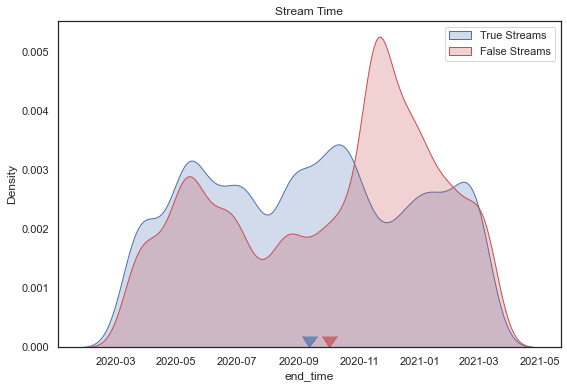

In [12]:
plot_kdeplot(true_streams, 'True Streams', false_streams, 'False Streams', 'end_time', 'Stream Time')

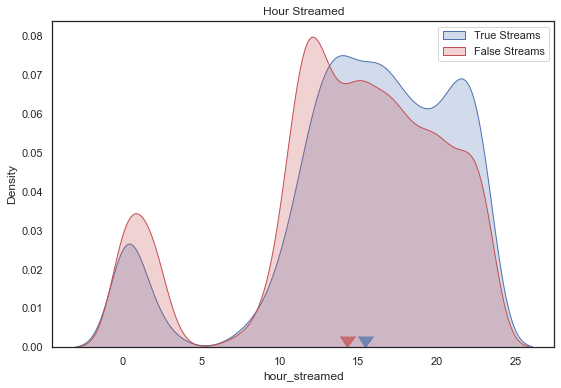

In [13]:
plot_kdeplot(true_streams, 'True Streams', false_streams, 'False Streams', 'hour_streamed', 'Hour Streamed')

We can tell from the above plots that on the scale of the year, I skipped many more songs in November, December, and January than in any other month. This is likely synonymous with a period of increased music exploration and hence by listening to more new songs, many more songs are skipped as I am discovering songs that I like as well as songs that I do not like. 

Let's make a new table `unique_streams` that only includes one row for each unique song found in `streams`. We can explore the audio features of these tracks using this table. 

In [14]:
unique_streams = true_streams.groupby(by = 'track_id', as_index = False).first()
unique_streams.index = unique_streams['track_key']
unique_false_streams = false_streams.groupby(by = 'track_id', as_index = False).first()
unique_false_streams.index = unique_false_streams['track_key']

# restrict to only streams that were never truly streamed
unique_false_streams = unique_false_streams[~unique_false_streams['track_id'].isin(unique_streams['track_id'])]

In [15]:
unique_streams.head()

,track_id,track_key,track_name,artist_name,album_name,artist_id,album_id,artist_genres,artist_followers,artist_popularity,album_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity,preview_url,tempo_calc,energy_mean,energy_var,energy_std,energy_min,energy_max,energy_median,energy_kurt,energy_skew,rms_mean,rms_var,rms_std,rms_min,rms_max,rms_median,rms_kurt,rms_skew,zcr_mean,zcr_var,zcr_std,zcr_min,zcr_max,zcr_median,zcr_kurt,zcr_skew,spec_flat_mean,spec_flat_var,spec_flat_std,spec_flat_min,spec_flat_max,spec_flat_median,spec_flat_kurt,spec_flat_skew,spec_cent_mean,spec_cent_var,spec_cent_std,spec_cent_min,spec_cent_max,spec_cent_median,spec_cent_kurt,spec_cent_skew,spec_band_mean,spec_band_var,spec_band_std,spec_band_min,spec_band_max,spec_band_median,spec_band_kurt,spec_band_skew,mfcc1_mean,mfcc1_var,mfcc1_std,mfcc1_med,mfcc1_min,mfcc1_max,mfcc1_kurt,mfcc1_skew,mfcc2_mean,mfcc2_var,mfcc2_std,mfcc2_med,mfcc2_min,mfcc2_max,mfcc2_kurt,mfcc2_skew,mfcc3_mean,mfcc3_var,mfcc3_std,mfcc3_med,mfcc3_min,mfcc3_max,mfcc3_kurt,mfcc3_skew,mfcc4_mean,mfcc4_var,mfcc4_std,mfcc4_med,mfcc4_min,mfcc4_max,mfcc4_kurt,mfcc4_skew,mfcc5_mean,mfcc5_var,mfcc5_std,mfcc5_med,mfcc5_min,mfcc5_max,mfcc5_kurt,mfcc5_skew,mfcc6_mean,mfcc6_var,mfcc6_std,mfcc6_med,mfcc6_min,mfcc6_max,mfcc6_kurt,mfcc6_skew,mfcc7_mean,mfcc7_var,mfcc7_std,mfcc7_med,mfcc7_min,mfcc7_max,mfcc7_kurt,mfcc7_skew,mfcc8_mean,mfcc8_var,mfcc8_std,mfcc8_med,mfcc8_min,mfcc8_max,mfcc8_kurt,mfcc8_skew,mfcc9_mean,mfcc9_var,mfcc9_std,mfcc9_med,mfcc9_min,mfcc9_max,mfcc9_kurt,mfcc9_skew,mfcc10_mean,mfcc10_var,mfcc10_std,mfcc10_med,mfcc10_min,mfcc10_max,mfcc10_kurt,mfcc10_skew,mfcc11_mean,mfcc11_var,mfcc11_std,mfcc11_med,mfcc11_min,mfcc11_max,mfcc11_kurt,mfcc11_skew,mfcc12_mean,mfcc12_var,mfcc12_std,mfcc12_med,mfcc12_min,mfcc12_max,mfcc12_kurt,mfcc12_skew,mfcc13_mean,mfcc13_var,mfcc13_std,mfcc13_med,mfcc13_min,mfcc13_max,mfcc13_kurt,mfcc13_skew,mfcc14_mean,mfcc14_var,mfcc14_std,mfcc14_med,mfcc14_min,mfcc14_max,mfcc14_kurt,mfcc14_skew,mfcc15_mean,mfcc15_var,mfcc15_std,mfcc15_med,mfcc15_min,mfcc15_max,mfcc15_kurt,mfcc15_skew,mfcc16_mean,mfcc16_var,mfcc16_std,mfcc16_med,mfcc16_min,mfcc16_max,mfcc16_kurt,mfcc16_skew,mfcc17_mean,mfcc17_var,mfcc17_std,mfcc17_med,mfcc17_min,mfcc17_max,mfcc17_kurt,mfcc17_skew,mfcc18_mean,mfcc18_var,mfcc18_std,mfcc18_med,mfcc18_min,mfcc18_max,mfcc18_kurt,mfcc18_skew,mfcc19_mean,mfcc19_var,mfcc19_std,mfcc19_med,mfcc19_min,mfcc19_max,mfcc19_kurt,mfcc19_skew,mfcc20_mean,mfcc20_var,mfcc20_std,mfcc20_med,mfcc20_min,mfcc20_max,mfcc20_kurt,mfcc20_skew,spec_cont1_mean,spec_cont1_var,spec_cont1_std,spec_cont1_med,spec_cont1_min,spec_cont1_max,spec_cont1_kurt,spec_cont1_skew,spec_cont2_mean,spec_cont2_var,spec_cont2_std,spec_cont2_med,spec_cont2_min,spec_cont2_max,spec_cont2_kurt,spec_cont2_skew,spec_cont3_mean,spec_cont3_var,spec_cont3_std,spec_cont3_med,spec_cont3_min,spec_cont3_max,spec_cont3_kurt,spec_cont3_skew,spec_cont4_mean,spec_cont4_var,spec_cont4_std,spec_cont4_med,spec_cont4_min,spec_cont4_max,spec_cont4_kurt,spec_cont4_skew,spec_cont5_mean,spec_cont5_var,spec_cont5_std,spec_cont5_med,spec_cont5_min,spec_cont5_max,spec_cont5_kurt,spec_cont5_skew,spec_cont6_mean,spec_cont6_var,spec_cont6_std,spec_cont6_med,spec_cont6_min,spec_cont6_max,spec_cont6_kurt,spec_cont6_skew,spec_cont7_mean,spec_cont7_var,spec_cont7_std,spec_cont7_med,spec_cont7_min,spec_cont7_max,spec_cont7_kurt,spec_cont7_skew,chroma1_mean,chroma1_var,chroma1_std,chroma1_med,chroma1_min,chroma1_max,chroma1_kurt,chroma1_skew,chroma2_mean,chroma2_var,chroma2_std,chroma2_med,chroma2_min,chroma2_max,chroma2_kurt,chroma2_skew,chroma3_mean,chroma3_var,chroma3_std,chroma3_med,chroma3_min,chroma3_max,chroma3_kurt,chroma3_skew,chroma4_mean,chroma4_var,chroma4_std,chroma4_med,chroma4_min,chroma4_max,chroma4_kurt,chroma4_skew,chroma5_mean,chroma5_var,chroma5_std,chroma5_med,chroma5_min,chroma5_max,chroma5_kurt,chroma5_skew

In [16]:
unique_false_streams.head()

,track_id,track_key,track_name,artist_name,album_name,artist_id,album_id,artist_genres,artist_followers,artist_popularity,album_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity,preview_url,tempo_calc,energy_mean,energy_var,energy_std,energy_min,energy_max,energy_median,energy_kurt,energy_skew,rms_mean,rms_var,rms_std,rms_min,rms_max,rms_median,rms_kurt,rms_skew,zcr_mean,zcr_var,zcr_std,zcr_min,zcr_max,zcr_median,zcr_kurt,zcr_skew,spec_flat_mean,spec_flat_var,spec_flat_std,spec_flat_min,spec_flat_max,spec_flat_median,spec_flat_kurt,spec_flat_skew,spec_cent_mean,spec_cent_var,spec_cent_std,spec_cent_min,spec_cent_max,spec_cent_median,spec_cent_kurt,spec_cent_skew,spec_band_mean,spec_band_var,spec_band_std,spec_band_min,spec_band_max,spec_band_median,spec_band_kurt,spec_band_skew,mfcc1_mean,mfcc1_var,mfcc1_std,mfcc1_med,mfcc1_min,mfcc1_max,mfcc1_kurt,mfcc1_skew,mfcc2_mean,mfcc2_var,mfcc2_std,mfcc2_med,mfcc2_min,mfcc2_max,mfcc2_kurt,mfcc2_skew,mfcc3_mean,mfcc3_var,mfcc3_std,mfcc3_med,mfcc3_min,mfcc3_max,mfcc3_kurt,mfcc3_skew,mfcc4_mean,mfcc4_var,mfcc4_std,mfcc4_med,mfcc4_min,mfcc4_max,mfcc4_kurt,mfcc4_skew,mfcc5_mean,mfcc5_var,mfcc5_std,mfcc5_med,mfcc5_min,mfcc5_max,mfcc5_kurt,mfcc5_skew,mfcc6_mean,mfcc6_var,mfcc6_std,mfcc6_med,mfcc6_min,mfcc6_max,mfcc6_kurt,mfcc6_skew,mfcc7_mean,mfcc7_var,mfcc7_std,mfcc7_med,mfcc7_min,mfcc7_max,mfcc7_kurt,mfcc7_skew,mfcc8_mean,mfcc8_var,mfcc8_std,mfcc8_med,mfcc8_min,mfcc8_max,mfcc8_kurt,mfcc8_skew,mfcc9_mean,mfcc9_var,mfcc9_std,mfcc9_med,mfcc9_min,mfcc9_max,mfcc9_kurt,mfcc9_skew,mfcc10_mean,mfcc10_var,mfcc10_std,mfcc10_med,mfcc10_min,mfcc10_max,mfcc10_kurt,mfcc10_skew,mfcc11_mean,mfcc11_var,mfcc11_std,mfcc11_med,mfcc11_min,mfcc11_max,mfcc11_kurt,mfcc11_skew,mfcc12_mean,mfcc12_var,mfcc12_std,mfcc12_med,mfcc12_min,mfcc12_max,mfcc12_kurt,mfcc12_skew,mfcc13_mean,mfcc13_var,mfcc13_std,mfcc13_med,mfcc13_min,mfcc13_max,mfcc13_kurt,mfcc13_skew,mfcc14_mean,mfcc14_var,mfcc14_std,mfcc14_med,mfcc14_min,mfcc14_max,mfcc14_kurt,mfcc14_skew,mfcc15_mean,mfcc15_var,mfcc15_std,mfcc15_med,mfcc15_min,mfcc15_max,mfcc15_kurt,mfcc15_skew,mfcc16_mean,mfcc16_var,mfcc16_std,mfcc16_med,mfcc16_min,mfcc16_max,mfcc16_kurt,mfcc16_skew,mfcc17_mean,mfcc17_var,mfcc17_std,mfcc17_med,mfcc17_min,mfcc17_max,mfcc17_kurt,mfcc17_skew,mfcc18_mean,mfcc18_var,mfcc18_std,mfcc18_med,mfcc18_min,mfcc18_max,mfcc18_kurt,mfcc18_skew,mfcc19_mean,mfcc19_var,mfcc19_std,mfcc19_med,mfcc19_min,mfcc19_max,mfcc19_kurt,mfcc19_skew,mfcc20_mean,mfcc20_var,mfcc20_std,mfcc20_med,mfcc20_min,mfcc20_max,mfcc20_kurt,mfcc20_skew,spec_cont1_mean,spec_cont1_var,spec_cont1_std,spec_cont1_med,spec_cont1_min,spec_cont1_max,spec_cont1_kurt,spec_cont1_skew,spec_cont2_mean,spec_cont2_var,spec_cont2_std,spec_cont2_med,spec_cont2_min,spec_cont2_max,spec_cont2_kurt,spec_cont2_skew,spec_cont3_mean,spec_cont3_var,spec_cont3_std,spec_cont3_med,spec_cont3_min,spec_cont3_max,spec_cont3_kurt,spec_cont3_skew,spec_cont4_mean,spec_cont4_var,spec_cont4_std,spec_cont4_med,spec_cont4_min,spec_cont4_max,spec_cont4_kurt,spec_cont4_skew,spec_cont5_mean,spec_cont5_var,spec_cont5_std,spec_cont5_med,spec_cont5_min,spec_cont5_max,spec_cont5_kurt,spec_cont5_skew,spec_cont6_mean,spec_cont6_var,spec_cont6_std,spec_cont6_med,spec_cont6_min,spec_cont6_max,spec_cont6_kurt,spec_cont6_skew,spec_cont7_mean,spec_cont7_var,spec_cont7_std,spec_cont7_med,spec_cont7_min,spec_cont7_max,spec_cont7_kurt,spec_cont7_skew,chroma1_mean,chroma1_var,chroma1_std,chroma1_med,chroma1_min,chroma1_max,chroma1_kurt,chroma1_skew,chroma2_mean,chroma2_var,chroma2_std,chroma2_med,chroma2_min,chroma2_max,chroma2_kurt,chroma2_skew,chroma3_mean,chroma3_var,chroma3_std,chroma3_med,chroma3_min,chroma3_max,chroma3_kurt,chroma3_skew,chroma4_mean,chroma4_var,chroma4_std,chroma4_med,chroma4_min,chroma4_max,chroma4_kurt,chroma4_skew,chroma5_mean,chroma5_var,chroma5_std,chroma5_med,chroma5_min,chroma5_max,chroma5_kurt,chroma5_skew

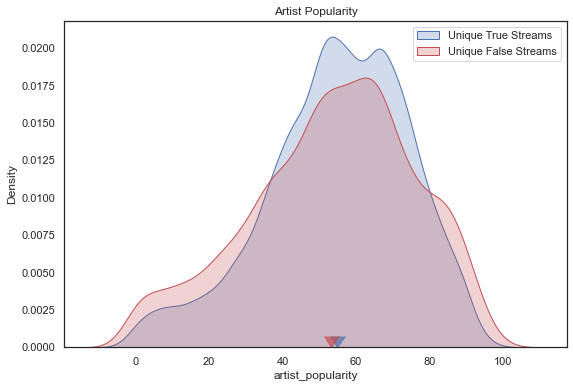

In [17]:
plot_kdeplot(unique_streams, 'Unique True Streams', unique_false_streams, 'Unique False Streams',
             'artist_popularity', 'Artist Popularity')

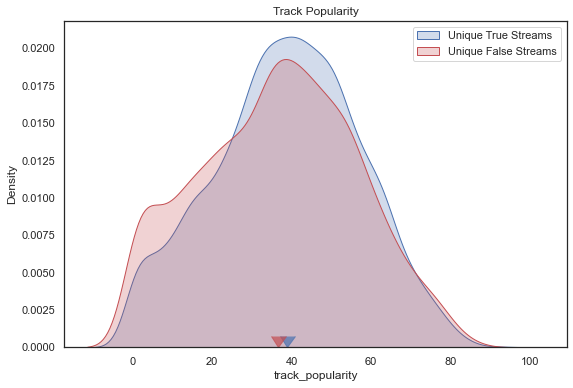

In [18]:
plot_kdeplot(unique_streams, 'Unique True Streams', unique_false_streams, 'Unique False Streams',
             'track_popularity', 'Track Popularity')

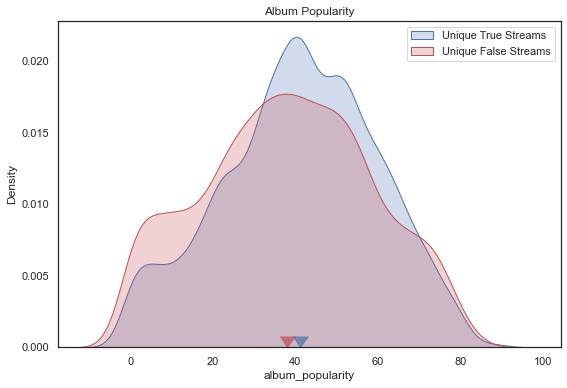

In [19]:
plot_kdeplot(unique_streams, 'Unique True Streams', unique_false_streams, 'Unique False Streams',
             'album_popularity', 'Album Popularity')

From the plots above, we can see that there are only minor differences in the popularity of tracks that were "truly" streamed and those that were not.

Let's explore whether or not the specific genres that I listen to change depending on the time of day:

In [20]:
night_streams = streams[(streams['hour_streamed'] > 22) | (streams['hour_streamed'] < 4)]
day_streams = streams[(streams['hour_streamed'] <= 22) | (streams['hour_streamed'] >= 4)]

# Collect all genres within night and day streams
day_genres_list = []
night_genres_list = []
for index, row in night_streams.iterrows():
    artist_genres = row['artist_genres']
    for genre in artist_genres:
        night_genres_list.append(genre)
for index, row in day_streams.iterrows():
    artist_genres = row['artist_genres']
    for genre in artist_genres:
        day_genres_list.append(genre)

In [21]:
day_genre_series = pd.Series(day_genres_list)
day_genre_series.value_counts()[:20]

indie soul           7467
electronica          5955
chillwave            4343
new rave             3929
alternative dance    3908
neo-psychedelic      3041
float house          3022
indietronica         2915
deep house           2312
indie rock           2204
rock                 2043
indie garage rock    1957
hip hop              1841
indie pop            1652
rap                  1622
modern rock          1609
escape room          1591
lo-fi house          1582
alternative r&b      1460
art pop              1273
dtype: int64

In [22]:
night_genre_series = pd.Series(night_genres_list)
night_genre_series.value_counts()[:20]

indie soul           1051
electronica           967
alternative dance     703
new rave              692
chillwave             622
indietronica          460
float house           401
neo-psychedelic       375
indie rock            366
indie pop             322
deep house            303
rock                  302
indie garage rock     295
hip hop               290
escape room           256
rap                   238
modern rock           235
lo-fi house           219
alternative r&b       216
nu disco              209
dtype: int64

While the genre make up of my day time and night time streams are not incredibly different, we can notice how certain genres either become slightly more popular or less popular to me such as "alternative dance", which becomes my number 3 genre at night rather than my number 5 genre during the day.

Lastly, let's explore for any differences in the average Spotify audio features of `unique_streams` and `unique_false_streams`:

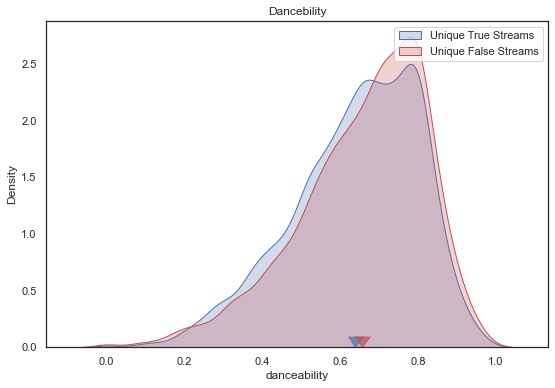

In [23]:
# On average, songs that I truly streamed are slightly less danceable than songs that I skipped
plot_kdeplot(unique_streams, 'Unique True Streams', unique_false_streams, 'Unique False Streams', 
             'danceability', 'Dancebility')

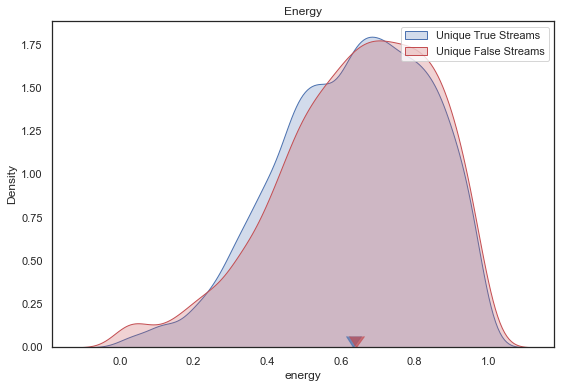

In [24]:
# On average, songs that I truly streamed are slightly less energetic than songs that I skipped
plot_kdeplot(unique_streams, 'Unique True Streams', unique_false_streams, 'Unique False Streams', 
             'energy', 'Energy')

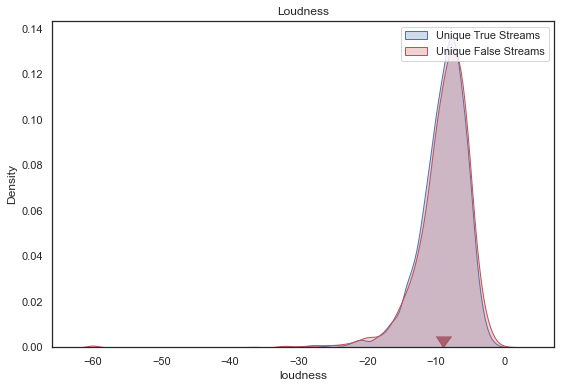

In [25]:
# On average, songs that I truly streamed have about the same loudness as songs that I skipped
plot_kdeplot(unique_streams, 'Unique True Streams', unique_false_streams, 'Unique False Streams', 
             'loudness', 'Loudness')

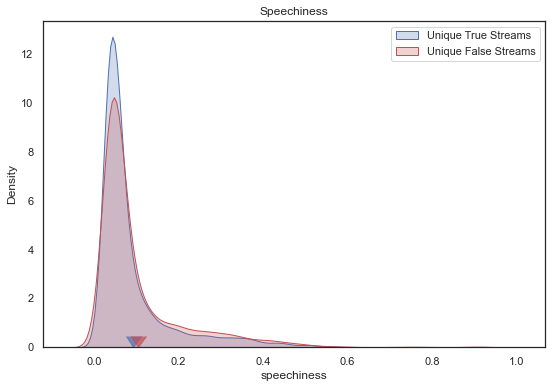

In [26]:
# On average, songs that I truly streamed are slightly less speechy than songs that I skipped
plot_kdeplot(unique_streams, 'Unique True Streams', unique_false_streams, 'Unique False Streams', 
             'speechiness', 'Speechiness')

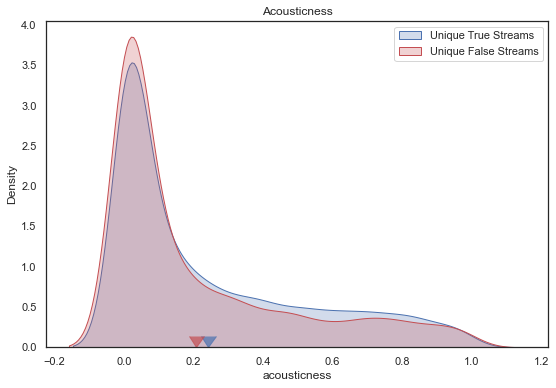

In [27]:
# On average, songs that I truly streamed are slightly more acousticness than songs that I skipped
plot_kdeplot(unique_streams, 'Unique True Streams', unique_false_streams, 'Unique False Streams', 
             'acousticness', 'Acousticness')

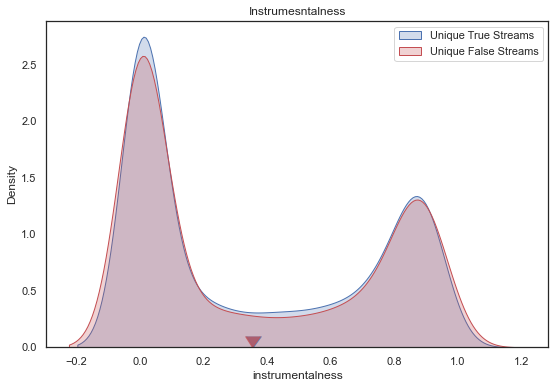

In [28]:
# On average, songs that I truly streamed have about the same instrumentalness as songs that I skipped
plot_kdeplot(unique_streams, 'Unique True Streams', unique_false_streams, 'Unique False Streams', 
             'instrumentalness', 'Instrumesntalness')

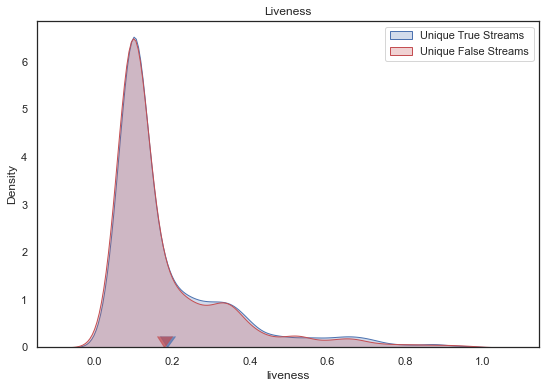

In [29]:
# On average, songs that I truly streamed are about just as live as songs that I skipped
plot_kdeplot(unique_streams, 'Unique True Streams', unique_false_streams, 'Unique False Streams', 
             'liveness', 'Liveness')

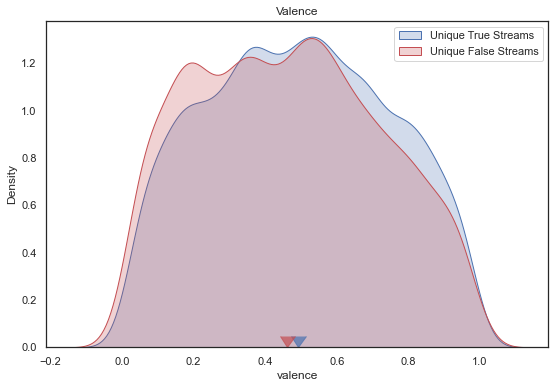

In [30]:
# On average, songs that I truly streamed have a slightly larger valence than songs that I skipped
plot_kdeplot(unique_streams, 'Unique True Streams', unique_false_streams, 'Unique False Streams', 
             'valence', 'Valence')

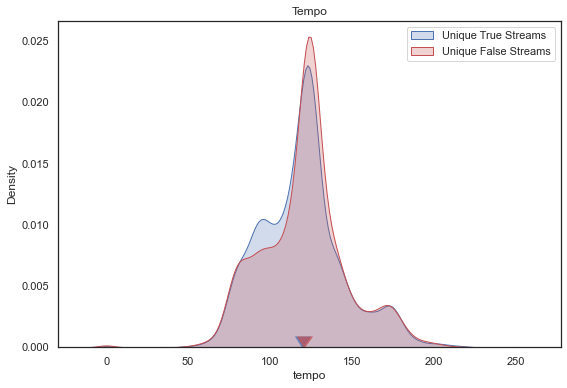

In [31]:
# On average, songs that I truly streamed have about the same tempo as songs that I skipped
plot_kdeplot(unique_streams, 'Unique True Streams', unique_false_streams, 'Unique False Streams', 
             'tempo', 'Tempo')

# Feature Engineering

### 'Personal Popularity' Design

We want to design a 'personal popularity' feature that captures many of the nuanced preferences of the specific listener's that the data provided is from. This score should describe the popularity on what may be the native listeners ranking system; one that measures the extent that the song captivates the listener. This score will capture nuances that are simply drowned out in measures of popularity informed by the entire user base of Spotify.

Potential ideas: 

- The maximum number of times a song was streamed over the year
- The largest number of days in which a track was frequently streamed
- A measure of how spread out streaming times of the track were

###### Number of times streamed:

This metric can be engineered by counting the number of times that each song was streamed. In this way, each song will be assigned a value that directly represents how personally popular that song was.

Now we can collect the number of times that each track was truly played and calculate the 'personal popularity'. Let's do that now:

In [32]:
counts_series = true_streams.value_counts('track_id')
true_streams = pd.merge(left = true_streams, right = pd.DataFrame(counts_series, columns = ['stream_count']),
                        how = 'left', left_on = 'track_id', right_on = 'track_id')
maximum_num_times_streamed = true_streams['stream_count'].max()

In [33]:
print(f'The maximum number of times that a song was streamed over the year was {maximum_num_times_streamed}' \
      ' times.')

The maximum number of times that a song was streamed over the year was 28 times.


In [34]:
true_streams['personal_popularity_1'] = true_streams['stream_count']

In [35]:
personal_popularity_1 = true_streams.groupby('track_id').first()[['personal_popularity_1']]

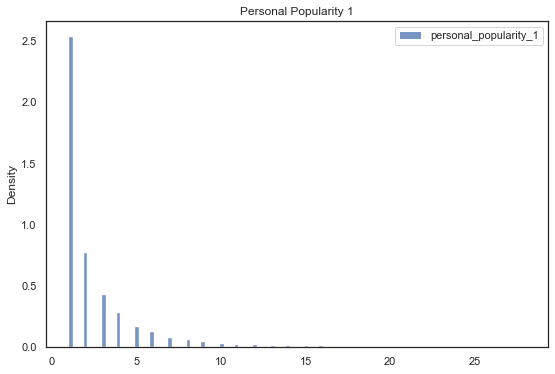

In [36]:
sns.histplot(personal_popularity_1, stat = 'density').set(title = 'Personal Popularity 1');

###### Duration of time that streaming was frequent:

This metric can be engineered as the successive number of days in which the track was played at least once on more days than not. This can also be thought of as the largest number of days in which the number of times the track was streamed is at least half the number of days that have passed.

Now we can define a function that will find the longest 'stream streak' and use it to add this second 'personal popularity' score, `personal_popularity_2`, to `true_streams`:

In [37]:
def find_longest_stream_streak(track_id, streams_table = true_streams):
    
    '''
    Finds the number of days of the longest stream streak of the track with the given track_id.
    
    A stream streak is defined as when a track is streamed at least half as many times
    as the number of days that have passed from the first listen of the streak. 
    '''
    
    # Collect the datetime objects of all the times that the track with track_id given was streamed
    streamed_track = streams_table[streams_table['track_id'] == track_id]
    streamed_track = streamed_track.sort_values('end_time')
    list_datetimes = list(streamed_track['end_time'])
    
    longest_streak = 0 
    for i in np.arange(len(list_datetimes)):
        
        stream_count_tracker = 1
        value = 1 # number of times streamed / number of days that have passed
        start_stream_time = list_datetimes[i]
        j = i
        
        # While the track was streamed at least half as many times as days that have passed in this streak...
        while (value >= 0.5) & (j+1 < len(list_datetimes)):
            j += 1
            next_stream_time = list_datetimes[j]
            days_between = (next_stream_time - start_stream_time)
            days_tracker = max(1, days_between.days + (days_between.seconds / (60*60*24)))
            stream_count_tracker += 1
            value = stream_count_tracker / days_tracker
    
        last_difference = list_datetimes[j-1] - start_stream_time
        streak = last_difference.days + (last_difference.seconds / (60*60*24))
        if streak > longest_streak:
            longest_streak = streak
    return longest_streak

In [38]:
true_streams['personal_popularity_2'] = true_streams['track_id'].apply(find_longest_stream_streak)

In [39]:
personal_popularity_2 = true_streams.groupby('track_id').first()[['personal_popularity_2']]

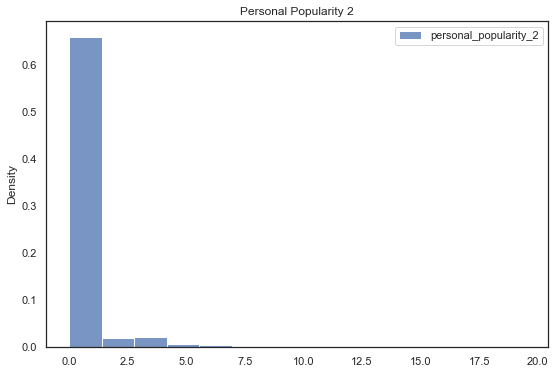

In [40]:
sns.histplot(personal_popularity_2, stat = 'density').set(title = 'Personal Popularity 2');

##### How spread out the times that the track was streamed were

This metric can be engineered as a measure of spread of the different times at which a single track was streamed. By looking at a measure of spread in the stream times of a single track, we can deduce whether this track gained a lot of streams in a short burst of time but was forgotten, or if the track accrued streams throughout the year with more spread. 


- Tracks with small measures of spread in their stream times did not have lasting effects on the listener -- they were interesting for a short burst, and either became old or did not captivate the listener enough to cause them to return after the initial burst of streams.
- Tracks with large measure of spread in their stream times as tracks that were largely captivating to the listener as it remained something the listener was interested in streaming for a longer period of time.

It makes sense to use the interquartile range here due to the fact that it is robust to outliers. If we used the variance or standard deviation instead, the values returned for a specific track could be largely increased due to a mere single stream occurring after a long period of not streaming said track. We want large values of spread to be conducive of a track being streamed fairly evenly over time.

Now we can define a function that will find the inter-quartile range and use it to add this third 'personal popularity' score, `personal_popularity_3`, to `true_streams`:

In [41]:
def times_IQR(track_id, streams_table = true_streams):
    
    '''
    Finds the inter-quartile ranage (in number of days) of the times that the track was streamed.
    Robust to outliers. 
    ''' 
    
    datetime_list = list(streams_table[streams_table['track_id'] == track_id]['end_time'])
        
    timestamp_list = list(map(dt.datetime.timestamp,datetime_list))
    
    # First quartile (Q1)
    Q1 = np.percentile(timestamp_list, 25, interpolation = 'midpoint')
  
    # Third quartile (Q3)
    Q3 = np.percentile(timestamp_list, 75, interpolation = 'midpoint')
  
    IQR = Q3 - Q1 # This value is in seconds so divide by number of seconds in a day to convert to days
    return IQR / (60*60*24)

In [42]:
true_streams['personal_popularity_3'] = true_streams['track_id'].apply(times_IQR)

In [43]:
personal_popularity_3 = true_streams.groupby('track_id').first()[['personal_popularity_3']]

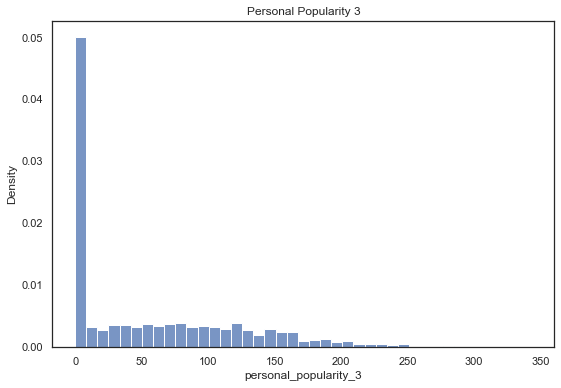

In [44]:
sns.histplot(true_streams['personal_popularity_3'], stat = 'density').set(title = 'Personal Popularity 3');

Let's add the `personal_popularity_1`, `personal_popularity_2`, and `personal_popularity_3` features to our `unique_streams` table:

In [45]:
personal_popularities = true_streams.groupby('track_id').first()[['personal_popularity_1',
                                                                  'personal_popularity_2',
                                                                  'personal_popularity_3']]

In [46]:
personal_popularities['track_id'] = personal_popularities.index
personal_popularities.index = np.arange(len(personal_popularities))

In [47]:
unique_streams = pd.merge(left = unique_streams, right = personal_popularities, on = 'track_id',
                          how = 'left')
unique_streams.index = unique_streams['track_key']

Let's now write the top 100 songs ranked by `personal_popularity_1`, `personal_popularity_2`, and `personal_popularity_3` to Spotify playlists for easy listening:

In [48]:
import spotipy

In [49]:
# Write top 100 most streamed tracks to Spotify playlist

top_100_personal_popularity_1 = list(unique_streams.sort_values(by = 'personal_popularity_1', ascending = False).iloc[:100]['track_id'])

token = utils.get_token()
sp = spotipy.Spotify(auth=token)
    
recom = sp.user_playlist_create('russyalgeo.','Your most popular tracks', public=True, collaborative=False,
                                description='Summer 2021')

new_playlist_id = recom['id']
new_playlist_link = recom['external_urls']
    
sp.playlist_add_items(new_playlist_id,top_100_personal_popularity_1)
print('Your most popular tracks created: ', new_playlist_link)

Your most popular tracks created:  {'spotify': 'https://open.spotify.com/playlist/2TsNry1w3lA49R4KdvXrRP'}


In [50]:
# Write top 100 bingeworthy tracks to spotify playlist


top_100_personal_popularity_2 = list(unique_streams.sort_values(by = 'personal_popularity_2', ascending = False).iloc[:100]['track_id'])
import spotipy
token = utils.get_token()
sp = spotipy.Spotify(auth=token)
    
recom = sp.user_playlist_create('russyalgeo.','Your binge worthy tracks', public=True, collaborative=False,
                                description='Summer 2021')
new_playlist_id = recom['id']
new_playlist_link = recom['external_urls']
    
sp.playlist_add_items(new_playlist_id,top_100_personal_popularity_2)
print('Your binge worthy tracks created: ', new_playlist_link)

Your binge worthy tracks created:  {'spotify': 'https://open.spotify.com/playlist/42MJ2up27EqG52qlumLU6t'}


In [51]:
# Write top 100 most dependable tracks to spotify playlist


top_100_personal_popularity_3 = list(unique_streams.sort_values(by = 'personal_popularity_3', ascending = False).iloc[:100]['track_id'])
import spotipy
token = utils.get_token()
sp = spotipy.Spotify(auth=token)
    
recom = sp.user_playlist_create('russyalgeo.','Your dependable tracks', public=True, collaborative=False,
                                description='Summer 2021')
new_playlist_id = recom['id']
new_playlist_link = recom['external_urls']

sp.playlist_add_items(new_playlist_id,top_100_personal_popularity_3)
print('Your dependable tracks created: ', new_playlist_link)

Your dependable tracks created:  {'spotify': 'https://open.spotify.com/playlist/3AZYqdzvybDwL1IvwiYV6o'}


### Binarizing `artistGenres`

In [52]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

By Binarizing the `artist_genres` feature of each song, we can use indicator variables of each unique genre as a feature to recognize similar songs. Below is an example of the artist genres for the artist 'RZA'

In [53]:
unique_streams.iloc[0]['artist_genres']

['alternative hip hop', 'east coast hip hop', 'hardcore hip hop', 'hip hop']

Rather than treating the multi-word genres as one genre, we will split each genre into its individual constituents, to prevent hyper-specific genres from being isolated from songs that may sound similar.

For example, the genre 'denton tx indie' is hyper-specific in the sense that it restricts the genre 'indie' to only songs from Denton, Texas. By splitting 'denton tx indie' into its constituents, songs from this genre can be associated with any other song that has 'indie' as one of its genre's constituents rather than only songs with the same 'denton tx indie' label for genre.

An example outcome of the process described above is shown below. Notice how the genres have been reduced to individual words.

In [54]:
[item for sublist in map(lambda x: x.split(' '), unique_streams.iloc[0]['artist_genres']) for item in sublist]

['alternative',
 'hip',
 'hop',
 'east',
 'coast',
 'hip',
 'hop',
 'hardcore',
 'hip',
 'hop',
 'hip',
 'hop']

Now we are ready to binarize the constituents of the `artistGenres` column of `unique_streams`

In [55]:
def find_all_constituents(column):
    '''
    Collects all constituents of a column.
    '''
    genres_set = set()
    for genre_list in column:
        genre_list = [item for sublist in map(lambda x: x.split(' '), genre_list) for item in sublist]
        for genre in genre_list:
            genres_set.add(genre)
    all_genres = list(genres_set)
    return all_genres

In [56]:
all_genres = find_all_constituents(saved_tracks['artist_genres'])

In [57]:
print(f'Your unique true streams come from {len(all_genres)} unique genre constituents')

Your unique true streams come from 797 unique genre constituents


Now, let's define some functions to binarize the genres associated with each song:

In [58]:
def binarize_genre(df, all_genres):
    '''
    Binarizes the 'artist_genres' feature of each song so that these hots can be used as a feature
    in recommendation.
    '''
    mlb = MultiLabelBinarizer()
    mlb.fit([all_genres])
    
    bow_encoding = pd.DataFrame(
        mlb.transform([[item for sublist in [genre.split(' ') for genre in genres] 
                        for item in sublist] for genres in df['artist_genres']]),
        columns=mlb.classes_,
        index = df.index)
    return bow_encoding

In [59]:
def center_standard(saved_tracks):
    '''
    Standardizes the saved_tracks DataFrame.
    '''

    scaler = StandardScaler()
    scaler = scaler.fit(saved_tracks)
    
    saved_tracks_scaled_values = scaler.transform(saved_tracks)
    saved_tracks_scaled = pd.DataFrame(saved_tracks_scaled_values, columns = saved_tracks.columns,
                                   index = saved_tracks.index)
    
    return saved_tracks_scaled

In [60]:
def prep_data(saved_tracks, columns_to_drop):
    '''
    Prepares the saved_tracks DataFrames by re-indexing, binarizing 'artist_genres', 
    dropping columns in columns_to_drop, and standardizing the data.
    '''
    
    all_genres = find_all_constituents(saved_tracks['artist_genres'])
    print(f'Your saved tracks come from {len(all_genres)} unique genre constituents')
    
    saved_tracks.index = [saved_tracks['track_name'], saved_tracks['artist_name'], saved_tracks['track_id']]
    saved_tracks_binarized = binarize_genre(saved_tracks, all_genres)
    saved_tracks = saved_tracks.drop(columns_to_drop, axis = 'columns').copy()

    saved_tracks = center_standard(saved_tracks)
    
    saved_tracks = saved_tracks.join(saved_tracks_binarized)
     
    return saved_tracks

Because we will be trying to identify songs that sound similar, should consider our features in that light. 
- While including more general identification metrics such as `album_name` and `artist_name` may lead to songs with high similarity (due to them being from the same album or artist), this will restrict our recoMmendations too narrow. More general metrics such as the tracks audio features or the binarized `artist_genres` will be better to use.
- Other identification metrics like `track_id`, `artist_id`, and `album_id` will be of no use to us as a feature as they are only defined for interaction with Spotify's API.
- If we include popularity metrics such as `artist_followers` and `track_popularity`, our recoMmended songs will likely fall in the same popularity tier, which will discriminate against tracks that may sound similar, but do not share similar popularity.

In [61]:
columns_to_drop = ['track_name', 'artist_name', 'album_name', 'track_id', 'artist_id', 'album_id',
                   'artist_genres', 'preview_url', 'key', 'mode', 'time_signature', 'added_at',
                  'artist_popularity', 'artist_followers', 'album_popularity', 'track_popularity']

In [62]:
saved_tracks_prepped = prep_data(saved_tracks, columns_to_drop)

Your saved tracks come from 797 unique genre constituents


In [63]:
saved_tracks_prepped = saved_tracks_prepped.dropna()
saved_tracks_prepped.head()

,,,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,tempo_calc,energy_mean,energy_var,energy_std,energy_min,energy_max,energy_median,energy_kurt,energy_skew,rms_mean,rms_var,rms_std,rms_min,rms_max,rms_median,rms_kurt,rms_skew,zcr_mean,zcr_var,zcr_std,zcr_min,zcr_max,zcr_median,zcr_kurt,zcr_skew,spec_flat_mean,spec_flat_var,spec_flat_std,spec_flat_min,spec_flat_max,spec_flat_median,spec_flat_kurt,spec_flat_skew,spec_cent_mean,spec_cent_var,spec_cent_std,spec_cent_min,spec_cent_max,spec_cent_median,spec_cent_kurt,spec_cent_skew,spec_band_mean,spec_band_var,spec_band_std,spec_band_min,spec_band_max,spec_band_median,spec_band_kurt,spec_band_skew,mfcc1_mean,mfcc1_var,mfcc1_std,mfcc1_med,mfcc1_min,mfcc1_max,mfcc1_kurt,mfcc1_skew,mfcc2_mean,mfcc2_var,mfcc2_std,mfcc2_med,mfcc2_min,mfcc2_max,mfcc2_kurt,mfcc2_skew,mfcc3_mean,mfcc3_var,mfcc3_std,mfcc3_med,mfcc3_min,mfcc3_max,mfcc3_kurt,mfcc3_skew,mfcc4_mean,mfcc4_var,mfcc4_std,mfcc4_med,mfcc4_min,mfcc4_max,mfcc4_kurt,mfcc4_skew,mfcc5_mean,mfcc5_var,mfcc5_std,mfcc5_med,mfcc5_min,mfcc5_max,mfcc5_kurt,mfcc5_skew,mfcc6_mean,mfcc6_var,mfcc6_std,mfcc6_med,mfcc6_min,mfcc6_max,mfcc6_kurt,mfcc6_skew,mfcc7_mean,mfcc7_var,mfcc7_std,mfcc7_med,mfcc7_min,mfcc7_max,mfcc7_kurt,mfcc7_skew,mfcc8_mean,mfcc8_var,mfcc8_std,mfcc8_med,mfcc8_min,mfcc8_max,mfcc8_kurt,mfcc8_skew,mfcc9_mean,mfcc9_var,mfcc9_std,mfcc9_med,mfcc9_min,mfcc9_max,mfcc9_kurt,mfcc9_skew,mfcc10_mean,mfcc10_var,mfcc10_std,mfcc10_med,mfcc10_min,mfcc10_max,mfcc10_kurt,mfcc10_skew,mfcc11_mean,mfcc11_var,mfcc11_std,mfcc11_med,mfcc11_min,mfcc11_max,mfcc11_kurt,mfcc11_skew,mfcc12_mean,mfcc12_var,mfcc12_std,mfcc12_med,mfcc12_min,mfcc12_max,mfcc12_kurt,mfcc12_skew,mfcc13_mean,mfcc13_var,mfcc13_std,mfcc13_med,mfcc13_min,mfcc13_max,mfcc13_kurt,mfcc13_skew,mfcc14_mean,mfcc14_var,mfcc14_std,mfcc14_med,mfcc14_min,mfcc14_max,mfcc14_kurt,mfcc14_skew,mfcc15_mean,mfcc15_var,mfcc15_std,mfcc15_med,mfcc15_min,mfcc15_max,mfcc15_kurt,mfcc15_skew,mfcc16_mean,mfcc16_var,mfcc16_std,mfcc16_med,mfcc16_min,mfcc16_max,mfcc16_kurt,mfcc16_skew,mfcc17_mean,mfcc17_var,mfcc17_std,mfcc17_med,mfcc17_min,mfcc17_max,mfcc17_kurt,mfcc17_skew,mfcc18_mean,mfcc18_var,mfcc18_std,mfcc18_med,mfcc18_min,mfcc18_max,mfcc18_kurt,mfcc18_skew,mfcc19_mean,mfcc19_var,mfcc19_std,mfcc19_med,mfcc19_min,mfcc19_max,mfcc19_kurt,mfcc19_skew,mfcc20_mean,mfcc20_var,mfcc20_std,mfcc20_med,mfcc20_min,mfcc20_max,mfcc20_kurt,mfcc20_skew,spec_cont1_mean,spec_cont1_var,spec_cont1_std,spec_cont1_med,spec_cont1_min,spec_cont1_max,spec_cont1_kurt,spec_cont1_skew,spec_cont2_mean,spec_cont2_var,spec_cont2_std,spec_cont2_med,spec_cont2_min,spec_cont2_max,spec_cont2_kurt,spec_cont2_skew,spec_cont3_mean,spec_cont3_var,spec_cont3_std,spec_cont3_med,spec_cont3_min,spec_cont3_max,spec_cont3_kurt,spec_cont3_skew,spec_cont4_mean,spec_cont4_var,spec_cont4_std,spec_cont4_med,spec_cont4_min,spec_cont4_max,spec_cont4_kurt,...,otacore,ottawa,outlaw,outsider,oxford,p,pagode,paillarde,palm,paso,paulista,permanent,perth,philly,phoenix,phonk,piano,pinoy,pittsburgh,plugg,plunderphonics,poetry,polish,political,pop,popgaze,popping,poptimism,portland,portuguese,post-bop,post-disco,post-grunge,post-hardcore,post-punk,post-rock,post-romantic,post-teen,power,power-pop,pre-war,progressive,proto-techno,protopunk,psicodelia,psych,psych-pop,psychedelic,psychill,pub,puerto,puertorriquena,puglia,punk,purple,quartet,quebec,quebecois,queen,queens,quiet,r&b,ragga,rai,ranchera,rap,rare,rave,raw,reading,reggae,regional,relaxative,renaissance,revival,rhode,rhythm,rican,riddim,rochester,rock,rock-and-roll,rockabilly,romanian,romantic,rominimal,room,roots,rumba,russian,sacramento,sad,saharan,salsa,samba,samba-jazz,san,saskatchewan,saxophone,scandinavian,scandipop,scene,schlager,school,schranz,score,scorecore,scottish,scratch,screwed,seattle,shibuya-kei,shimmer,shiver,shoegaze,show,singer-songwriter,ska,skool,skweee,sky,slam,slap,slovak,slovenian,slowcore,small,smooth,smp,soca,socal,social,soft,s

Now that our data has been prepped, let's seperate each DataFrame into unique combinations of features. In doing so, we can identify how each combination of features results in different nuances in recommendations.

In [64]:
saved_tracks_spotify_audio_features = saved_tracks_prepped.loc[:, 'danceability':'duration_ms']

saved_tracks_spotify_audio_features_and_genres = saved_tracks_spotify_audio_features.join(saved_tracks_prepped.loc[:, '432hz':])

saved_tracks_calculated_audio_features = saved_tracks_prepped.loc[:, 'tempo_calc':'tonnetz6_skew']

saved_tracks_calculated_audio_features_and_genres = saved_tracks_calculated_audio_features.join(saved_tracks_prepped.loc[:, '432hz':])

saved_tracks_all_but_genres = saved_tracks_prepped.drop(saved_tracks_prepped.loc[:, '432hz':], axis = 1)

saved_tracks_all = saved_tracks_prepped.copy()

## Discovery

In [65]:
from sklearn.neighbors import  NearestNeighbors

Now that the data is prepped, we can begin working with the data to achieve recommendations and other discoveries!

First, let's define some functions to collect recommendations via a Nearest Neighbor model:

In [66]:
def get_recommendations(song_title, saved_tracks_df, show = True):
    '''
    Collects 15 recommendations for the song with the song_title passed in by training a Nearest Neighbor
    model and querying for the 15 nearest neighbors.
    '''

    model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn.fit(saved_tracks_df)

    query_song = saved_tracks_df.xs(song_title, level = 0)
    query_song_values = query_song.values[0]

    distances, indices = model_knn.kneighbors(query_song_values.reshape(1, -1), n_neighbors=16)
    return_list = []

    if show:
        print(f'Recommendations for {song_title} by {query_song.index[0][0]}')
    for i in range(1,len(distances.flatten())):
        if show:
            print(f'{i} : {saved_tracks_df.index[indices.flatten()[i]][0]} by {saved_tracks_df.index[indices.flatten()[i]][1]}, with distance of {distances.flatten()[i]}')
        return_list.append([saved_tracks_df.index[indices.flatten()[i]][2], f'{saved_tracks_df.index[indices.flatten()[i]][0]} by {saved_tracks_df.index[indices.flatten()[i]][1]}'])
    return return_list

In [67]:
def create_playlist(playlist_name, track_ids):
    '''
    Cresates a new Spotify playlist with the playlist_name given and tracks with corresponding track_ids given
    '''
    token = utils.get_token()
    sp = spotipy.Spotify(auth=token)

    new_playlist = sp.user_playlist_create('russyalgeo.',playlist_name, public=True, collaborative=False)
    new_playlist_id = new_playlist['id']
    
    if len(track_ids) > 100:
        rest_track_ids = track_ids
        while len(rest_track_ids) > 50:
            curr_track_ids = rest_track_ids[:50]
            rest_track_ids = rest_track_ids[50:]
            sp.playlist_add_items(new_playlist_id,curr_track_ids)
            token = utils.get_token()
            sp = spotipy.Spotify(auth = token)
        sp.playlist_add_items(new_playlist_id,rest_track_ids)
    else: 
        sp.playlist_add_items(new_playlist_id,track_ids)
    
    playlist_link = new_playlist['external_urls']
    print(f'{playlist_name} created: ', playlist_link)
    return playlist_link

Below we can see an example of the songs recommended for a track called "SFX / ORY" by Sebo K. We can see that across the different combinations of features being used for recommendation, the recommended tracks have lots of overlap. To make our final recommendation playlist, we will make a set of all the songs recommended and add to a playlist from that.

In [68]:
calc_audio_feats_and_genres = get_recommendations('SFX / ORY', saved_tracks_calculated_audio_features_and_genres)

Recommendations for SFX / ORY by Sebo K
1 : Jumbo by Dimmish, with distance of 0.37914714277303585
2 : Sleepless Nights by DJ Danny Phantom, with distance of 0.39501629231496216
3 : Dreamers by Enzo Siragusa, with distance of 0.4066021077530647
4 : Chi Boost by Zenker Brothers, with distance of 0.40704143170546847
5 : Swerve - Original Mix by Archie Hamilton, with distance of 0.41408365169254224
6 : Along Came Polly - Original Mix by Rebūke, with distance of 0.4163224770137005
7 : Politics Of Dancing X Chris Stussy by Politics of Dancing, with distance of 0.4172743972182176
8 : Tresor by Lauren Lo Sung, with distance of 0.41871221834137307
9 : Memory Lake by Special Request, with distance of 0.42548629920876024
10 : Paradigm Shift by Enzo Siragusa, with distance of 0.43369218826377864
11 : Pkd by Arctor, with distance of 0.4340635792740877
12 : VCO Mfkr by Crue, with distance of 0.43595064520249704
13 : Drum Therapy by Chaos In The CBD, with distance of 0.44186037082318563
14 : Derby T

In [69]:
all_feats = get_recommendations("SFX / ORY", saved_tracks_all)

Recommendations for SFX / ORY by Sebo K
1 : Jumbo by Dimmish, with distance of 0.3755217390153792
2 : Sleepless Nights by DJ Danny Phantom, with distance of 0.3915188305552316
3 : Dreamers by Enzo Siragusa, with distance of 0.40233106041126376
4 : Chi Boost by Zenker Brothers, with distance of 0.402900076075277
5 : Swerve - Original Mix by Archie Hamilton, with distance of 0.40899354240983155
6 : Politics Of Dancing X Chris Stussy by Politics of Dancing, with distance of 0.4139650174733439
7 : Tresor by Lauren Lo Sung, with distance of 0.4143748844981504
8 : Along Came Polly - Original Mix by Rebūke, with distance of 0.41770805459842175
9 : Memory Lake by Special Request, with distance of 0.42392006079381916
10 : Paradigm Shift by Enzo Siragusa, with distance of 0.42986211111450057
11 : VCO Mfkr by Crue, with distance of 0.43137868304802984
12 : Pkd by Arctor, with distance of 0.43260766805894135
13 : Derby Tackle by Darius Syrossian, with distance of 0.43980528013160725
14 : Drum Ther

In [70]:
spot_audio_feats_and_genres = get_recommendations("SFX / ORY", saved_tracks_spotify_audio_features_and_genres)

Recommendations for SFX / ORY by Sebo K
1 : Let You Go by DJOKO, with distance of 0.08555311129028187
2 : Mind on Prisma by Fabe (Ger), with distance of 0.09856198445809405
3 : Soulmakers - Pulshar Remix by Mathias Kaden, with distance of 0.11449782300043398
4 : Water Tower by Fabe (Ger), with distance of 0.14908195846024186
5 : Luxuria by Traumer, with distance of 0.14923647871729906
6 : Feelings by Rossi., with distance of 0.15017514537676557
7 : Mind Blank - Original Mix by Archie Hamilton, with distance of 0.15462941112762052
8 : Don't Compare Yourself by DJOKO, with distance of 0.15718265941451504
9 : Kickin It by Rossi., with distance of 0.1647290277933242
10 : In Public by Tigerskin, with distance of 0.1650632014009359
11 : Jode Lade by DJOKO, with distance of 0.1689881292548021
12 : Beautiful Emi by Enzo Siragusa, with distance of 0.17245004915348394
13 : Duke by DJOKO, with distance of 0.17284272362321706
14 : Pressure Baby by Lazare Hoche, with distance of 0.17791817660605813

 Next, we will create playlists based on these recommendations for ease of listening. The first song in each playlist is always the song that we are recommending against. You can access any of the playlists via the link printed below each call to `create_playlists`.

In [71]:
def create_playlists(song_title, show = False):
    data = {'spot audio feats and genres': saved_tracks_spotify_audio_features_and_genres, 
           'calc audio feats and genres' : saved_tracks_calculated_audio_features_and_genres, 
            'all' : saved_tracks_all}
    query_id = saved_tracks_all.xs(song_title, level = 0).index[0][1]
    ids = []
    for key, value in data.items():
        response = get_recommendations(song_title, value, show)
        curr_ids = [value[0] for value in response]
        ids += curr_ids
    ids = list(set(ids))
    playlist_ids = [query_id] + ids
    playlist_title = f'Recommendations for {song_title}'
    playlist_link = create_playlist(playlist_title, playlist_ids)
    return playlist_link

In [72]:
sfx_ory_link = create_playlists("SFX / ORY")

Recommendations for SFX / ORY created:  {'spotify': 'https://open.spotify.com/playlist/4ukli7noVUxo2kDE9mfv4W'}


In [73]:
it_swims_here_link = create_playlists("It Swims Here")

Recommendations for It Swims Here created:  {'spotify': 'https://open.spotify.com/playlist/0qlqvoGqAQyXKxwBlR39Aa'}


In [74]:
releif_rinse_link = create_playlists("Relief Rinse")

Recommendations for Relief Rinse created:  {'spotify': 'https://open.spotify.com/playlist/3hDqXVPaxn00wbAd2FWmO7'}


In [75]:
soul_beat_runna_link = create_playlists("Soul Beat Runna")

Recommendations for Soul Beat Runna created:  {'spotify': 'https://open.spotify.com/playlist/7IDRATVHbLYTeICRBHNICp'}


Beyond recommending songs that are similar to a song of interest, we can also use the vector representations of each song to find songs that represent a good blend of any arbitrary number of songs. I will refer to this as finding the song average.

Let's define a function to calculate the mean vector of a list of songs and return recommendations for songs similar to this average.

In [76]:
def get_song_average(song_titles, saved_tracks_df):
    '''
    Collects recomendations for songs that represent an "average" of the songs with the titles
    passed in song_titles
    '''
    
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn.fit(saved_tracks_df)

    values_list = []
    for song_title in song_titles: 
        
        query_song = saved_tracks_df.xs(song_title, level = 0).values[0]
        values_list.append(query_song)
    
    resulting_song = np.mean(values_list, axis = 0)

    distances, indices = model_knn.kneighbors(resulting_song.reshape(1, -1), n_neighbors=15+len(song_titles))
    return_list = []

    print(f'Recommendations for average song of {song_titles}')
    for i in range(0, len(distances.flatten())):
        
        print(f'{i} : {saved_tracks_df.index[indices.flatten()[i]][0]} by {saved_tracks_df.index[indices.flatten()[i]][1]}, with distance of {distances.flatten()[i]}')
        return_list.append(f'{saved_tracks_df.index[indices.flatten()[i]][0]} by {saved_tracks_df.index[indices.flatten()[i]][1]}')
        
    return return_list

In [77]:
song_average = get_song_average(["Moonlight", "EARFQUAKE"], saved_tracks_all_but_genres)

Recommendations for average song of ['Moonlight', 'EARFQUAKE']
0 : EARFQUAKE by Tyler, The Creator, with distance of 0.10623082559436015
1 : Moonlight by Tribal Seeds, with distance of 0.3013978738451023
2 : Ugotme by Omar Apollo, with distance of 0.37215189662762205
3 : Freestyle 4 by Kanye West, with distance of 0.3839780323254286
4 : Choices (Yup) by E-40, with distance of 0.4049134746892792
5 : You've Been Missed by PARTYNEXTDOOR, with distance of 0.4064885715325339
6 : Other Shit by Playboi Carti, with distance of 0.40656683466377064
7 : Had 2 by Playboi Carti, with distance of 0.40812881032735315
8 : Off the Land by Kodak Black, with distance of 0.4190159561179694
9 : Took You Seriously by Amir Obe, with distance of 0.4313301127710054
10 : Us (How Sweet It Was) by Ricky Reed, with distance of 0.4371299383998505
11 : Jewel by Flume, with distance of 0.4378622802047789
12 : Back Up (feat. Big Sean) by DeJ Loaf, with distance of 0.4422735115932258
13 : Chaka Con Artist by Herobust, 

Lastly, we can take the difference of two songs to arrive at a resulting vector. By recommending from this vector, we can discover arithmetic patterns in tracks. 

In [78]:
def get_song_difference(song1_title, song2_title, saved_tracks_df):
    '''
    Collects recommendations for songs that represent the arithmetic difference of two songs given as
    song1_title, and song2_title
    '''
    
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn.fit(saved_tracks_df)

    query_song1 = saved_tracks_df.xs(song1_title, level = 0).values[0]
    query_song2 = saved_tracks_df.xs(song2_title, level = 0).values[0]
    
    resulting_diff = query_song1 - query_song2

    distances, indices = model_knn.kneighbors(resulting_diff.reshape(1, -1), n_neighbors=17)
    return_list = []

    for i in range(0,len(distances.flatten())):
    
        print(f'{i} : {saved_tracks_df.index[indices.flatten()[i]][0]} by {saved_tracks_df.index[indices.flatten()[i]][1]}, with distance of {distances.flatten()[i]}')
        return_list.append(f'{saved_tracks_df.index[indices.flatten()[i]][0]} by {saved_tracks_df.index[indices.flatten()[i]][1]}')
    return return_list

In [79]:
get_song_difference('EARFQUAKE', 'SFX / ORY', saved_tracks_all_but_genres);

0 : EARFQUAKE by Tyler, The Creator, with distance of 0.14326477234764878
1 : Freestyle 4 by Kanye West, with distance of 0.42137951159928344
2 : Bound 2 by Kanye West, with distance of 0.4399828762134914
3 : Garden Shed (feat. Estelle) by Tyler, The Creator, with distance of 0.45190895153921906
4 : Wavy (Interlude) (feat. James Fauntleroy) by SZA, with distance of 0.45320602192660253
5 : Fuck Love (feat. Trippie Redd) by XXXTENTACION, with distance of 0.45461812340489527
6 : Good Lovin' by Leven Kali, with distance of 0.4645221888216887
7 : family ties (with Kendrick Lamar) by Baby Keem, with distance of 0.46628671947421463
8 : Jewel by Flume, with distance of 0.4676671420428433
9 : 19 by Jackie Hayes, with distance of 0.4731480812739526
10 : Dionysian State by Mild High Club, with distance of 0.4758142800115833
11 : Off the Land by Kodak Black, with distance of 0.47839343020563274
12 : Is It Cold In The Water? - Flume & Eprom Remix by Flume, with distance of 0.4788615826721804
13 : W

We've successfully made recommendations by looking at similar songs in terms of euclidean distance via K-Neighbors models! We have also explored possible discovery through preforming arithmetic operations on song vectors to recommend against resulting "average" songs and "difference of" songs. 

In the future I would like to build this out into a web tool so that it is much easier for other users to log in and take part in the same music discovery we just took place in!